In [22]:
import sys
import os

sys.path.append(os.path.abspath("../src"))

In [23]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from segmentation.segmenter import Segmenter
from ultralytics import YOLO

SEED = 42

class Inference:
    def __init__(self, model_path, file_path):
        self.model = Segmenter(model_path, conf_thresh=0.5)
        self.video_model = YOLO(model_path)
        self.file_path = file_path
        self.n_classes = len(self.model.class_names)
        self.image_exts = ['.jpg', '.jpeg', '.webp', '.png']
        self.video_exts = ['.mp4', '.mov', '.avi', '.mkv']

        random.seed(SEED)
        self.colors = [tuple([random.random() for _ in range(3)]) for _ in range(self.n_classes)]

    def get_class_color(self, cls_id):
        return self.colors[cls_id % len(self.colors)]

    def visualize_prediction(self, img, results, draw_masks=True):
        _, ax = plt.subplots(figsize=(12, 8))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img_rgb)

        for i in range(len(results["boxes"])):
            box = results["boxes"][i]
            cls_id = results["classes"][i]
            confidence = results["confidences"][i]
            x0, y0, x1, y1 = map(int, box)

            label = self.model.class_names[cls_id]
            text = f'{label} {confidence:.2f}'
            color = self.get_class_color(cls_id)

            rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                    linewidth=1.0, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            ax.text(x0, y0, text,
                    verticalalignment='top',
                    bbox=dict(facecolor='black', alpha=0.7, pad=1, edgecolor='none'),
                    color='white',
                    fontsize=8,
                    fontweight='normal')

            # draw polygon mask
            if draw_masks and results["masks"][i] is not None:
                polygon = np.array(results["masks"][i], dtype=np.int32)
                poly_patch = patches.Polygon(polygon, closed=True, facecolor=color, alpha=0.45, edgecolor='none')
                ax.add_patch(poly_patch)

        ax.axis('off')
        ax.set_title('YOLO Predictions + Masks' if draw_masks else 'YOLO Predictions')
        plt.tight_layout()
        plt.show()


    def run(self, draw_masks=True):
        ext = os.path.splitext(self.file_path)[-1].lower()

        if ext in self.image_exts:
            img = cv2.imread(self.file_path)
            # if img is None:
            #     raise ValueError(f'Could not load image at {self.file_path}') # used in Segmenter
            results = self.model.predict(img)
            self.visualize_prediction(img, results, draw_masks)

        elif ext in self.video_exts:

            model = self.video_model
            results = model(self.file_path, stream=True, verbose=False)
            out = None

            for result in results:
                annotated_frame = result.plot()
                if out is None:
                    frame_height, frame_width = annotated_frame.shape[:2]
                    # out = cv2.VideoWriter("output.mp4", cv2.VideoWriter_fourcc(*"mp4v"), 30, (frame_width, frame_height))
                    out = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"XVID"), 30, (frame_width, frame_height))
                if annotated_frame.shape[2] == 4:
                    annotated_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGRA2BGR)
                out.write(annotated_frame)
                cv2.imshow("YOLO CoreML Inference", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            if out:
                out.release()
            cv2.destroyAllWindows()

        else:
            raise ValueError(f"Unsupported file format: {ext}")

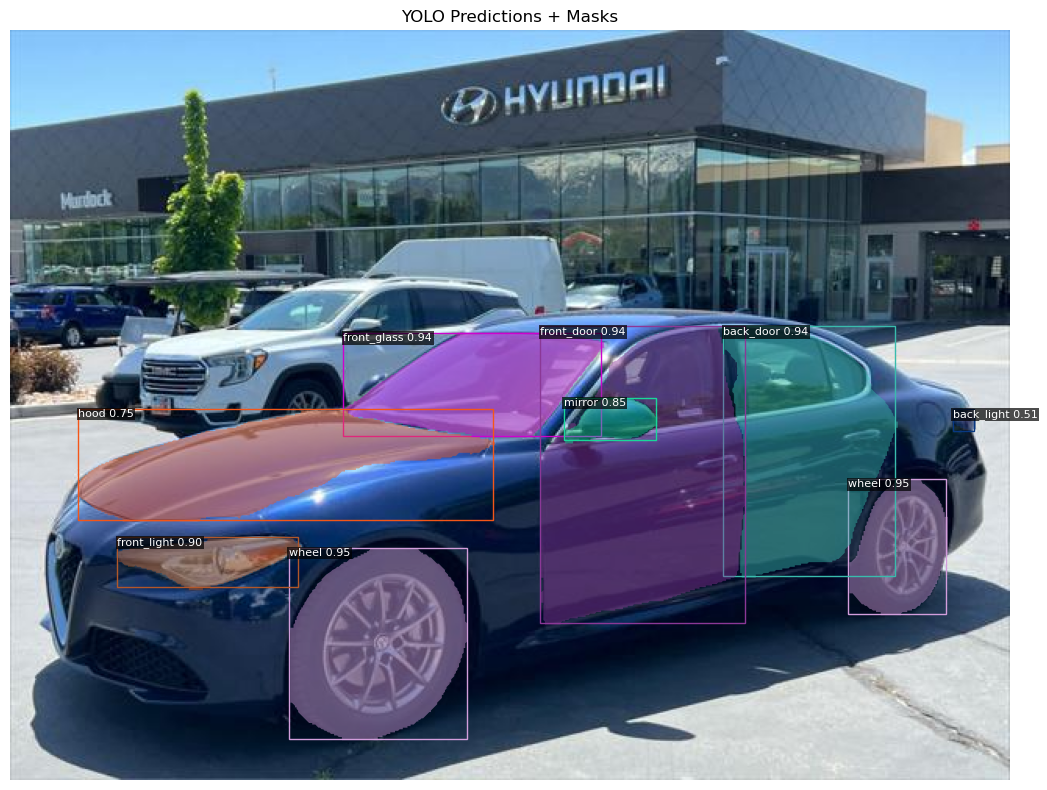

In [ ]:
model_path = 'path/to/model'
file_path = 'path/to/file'

infer = Inference(model_path, file_path)
infer.run(draw_masks=True)